<a href="https://colab.research.google.com/github/ddevMetal/CSIT128/blob/main/Copy_of_UOW_Lab_4_CNN_exercise_2_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CNN implementation using PyTorch
Sample dataset: Minist


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Why normalize the data to [-1,1]?
1. Centered data: Helps the model learn better by avoiding large weight updates.
2. Consistency: Neural networks often perform better when input data has a mean close to 0 and a consistent range of values.

In [ ]:
# Check for GPU
# If a GPU is available, it sets device to 'cuda'. Otherwise, it uses 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Define transformations (normalize the dataset)
transform = transforms.Compose([
    transforms.ToTensor(), #Converts the image to a PyTorch tensor; Scale to [0,1]
    transforms.Normalize((0.5,), (0.5,))  # Normalize MNIST images to range of [-1,1]
    #Step 1: Original curve: [0,1]
    #Step 2: Move the curve to the left by 0.5 so that it centers around zero
    #Step 3: Divide the curve by 0.5 so that it ranges from [-1,1]
])

# Download and load the dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Define data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

Using device: cpu
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 20.3MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 634kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.88MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.14MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



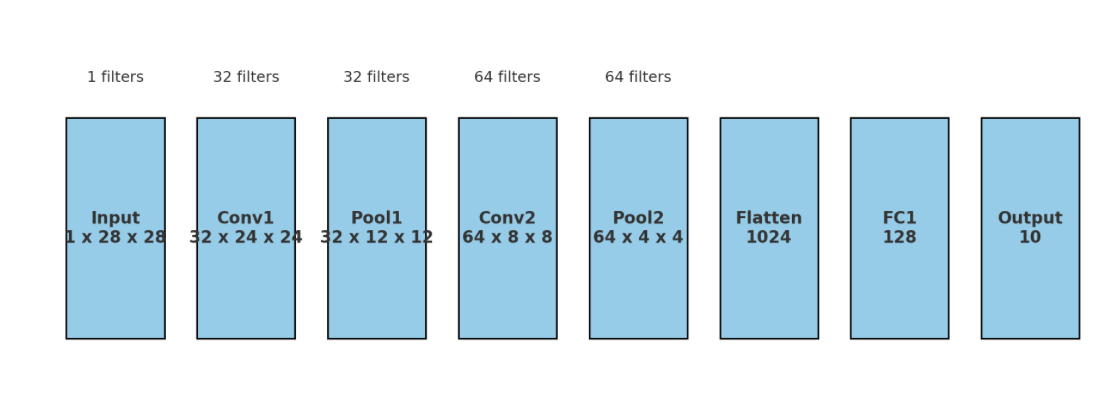

The above diagram shows CNN architecture flow.
1. Input image size: 28x28x1 (gray scale)
2. Conv1: 32 filters (5x5), stride=1, padding=0. This yield 32 sets of 24x24 feature maps.
3. Pool1: Max pool i.e. choose the higher pixel value (1 out of 2). Hence, 32 sets of 12x12.
4. Conv2: 64 filters (5x5), stride=1, padding=0. This yields 64 sets of 8x8 feature maps.
5. Pool2: Max pool. Hence, 64 sets of 4x4 feature maps.
6. Flatten the layer: 64x4x4=1024
7. FC1: Pass this flattened layer to a dense layer of 128 neurons. (arbitrary choice of number).
8. Output layer: 10 classes (digit recognition 0-9)

In [ ]:
# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=0)  # 28x28 -> 24x24
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 24x24 -> 12x12
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=0)  # 12x12 -> 8x8
        self.fc1 = nn.Linear(64 * 4 * 4, 128)  # Flattened size: 64 * 4 * 4
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model, define the loss function and optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
num_epochs = 5
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

Epoch [1/5], Loss: 0.1764
Epoch [2/5], Loss: 0.0475
Epoch [3/5], Loss: 0.0324
Epoch [4/5], Loss: 0.0237
Epoch [5/5], Loss: 0.0194


In [ ]:
# Evaluate the model on the test set
model.eval()
correct = 0
total = 0
test_loss = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Get predictions
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
test_loss /= len(test_loader)
print(f'Test Accuracy: {test_accuracy:.2f}%, Test Loss: {test_loss:.4f}')

Test Accuracy: 99.12%, Test Loss: 0.0278


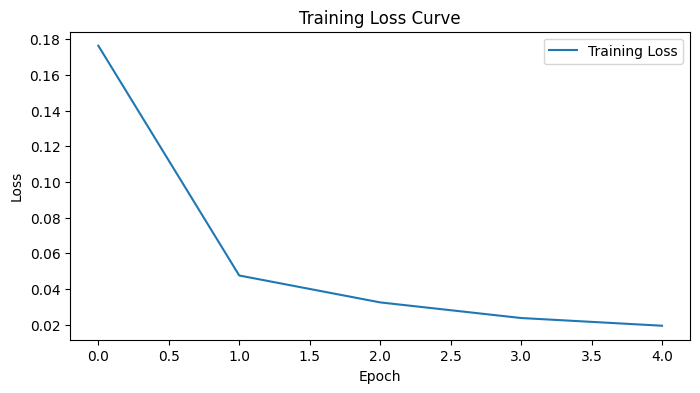

In [ ]:
# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

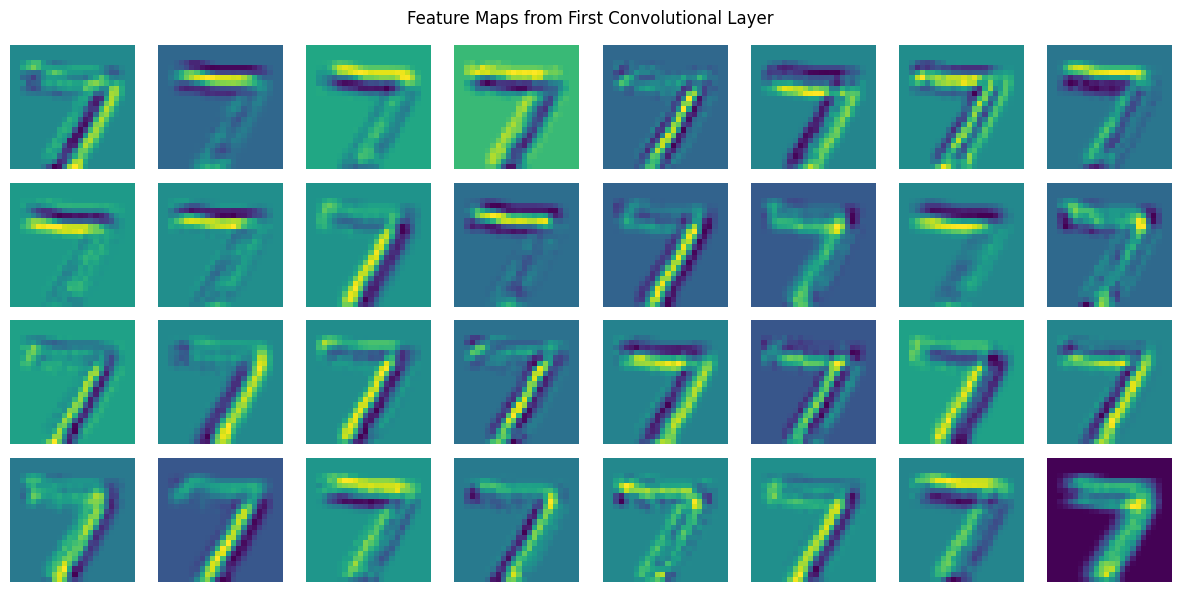

In [ ]:
# Function to visualize feature maps from a specific layer
def visualize_feature_maps(model, image):
    model.eval()

    # Pass the image through the first convolutional layer
    with torch.no_grad():
        conv1_output = model.conv1(image)

    # Plot the feature maps
    num_filters = conv1_output.shape[1]
    fig, axes = plt.subplots(4, 8, figsize=(12, 6))

    for i, ax in enumerate(axes.flat):
        if i < num_filters:
            ax.imshow(conv1_output[0, i].cpu().numpy(), cmap='viridis')
            ax.axis('off')

    plt.suptitle('Feature Maps from First Convolutional Layer')
    plt.tight_layout()
    plt.show()

# Select a test image
sample_image, _ = test_dataset[0]
sample_image = sample_image.unsqueeze(0).to(device)  # Add batch dimension

# Visualize feature maps
visualize_feature_maps(model, sample_image)